# Sentinel 1 Flood Finder 

The `S1FloodFinder` package has two main classes: `FloodProcessor` and `ProcessorReporter`.


## The `FloodProcessor` class

The `FloodProcessor` class is the main class that will be used to create the water extensions and flooded area series. To create a `FloodReport` instance, we will need an Area of Interest (AOI) to be passed as a GeoPandas GeoDataFrame. Note that the area to be considered is the bounding box of all the polygons within the DataFrame. 

### Select a ROI

To select a region of interest, we can make use of the `geojson.io` interactive map that outputs the `GeoJson` representation of a polygon. In the following example, I've created a Polygon (box) around the city of Alegrete-RS, Brazil. This ROI is a Feature Collection and will be imported to a GeoDataFrame.

In [12]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from flood_finder.floodprocessor import FloodProcessor
from flood_finder.reporter import ProcessorReporter

roi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -55.85381630956452,
              -29.75258818268783
            ],
            [
              -55.85381630956452,
              -29.829051778923365
            ],
            [
              -55.73479957129133,
              -29.829051778923365
            ],
            [
              -55.73479957129133,
              -29.75258818268783
            ],
            [
              -55.85381630956452,
              -29.75258818268783
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

# write the ROI to a GeoDataFrame
# PS: We need to make sure the Coordinate Reference System is set
gdf = gpd.GeoDataFrame.from_features(roi).set_crs('epsg:4326')

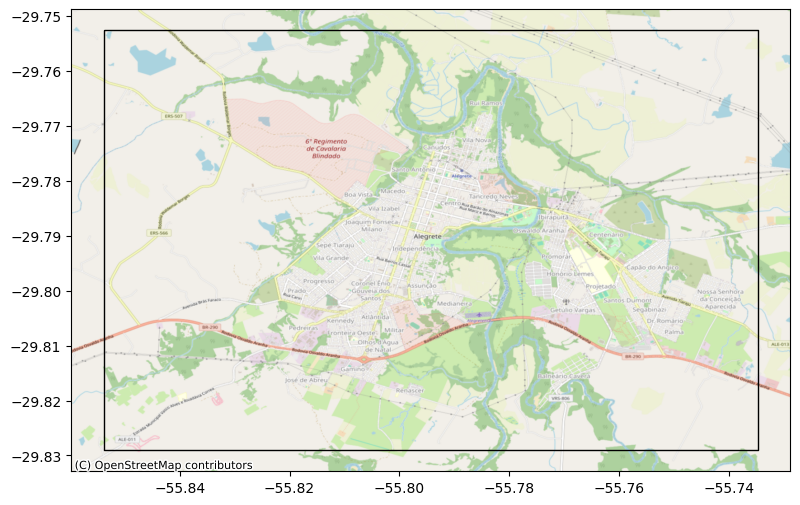

In [2]:
# Plot a context map using contextily
ax = gdf.plot(facecolor='none', figsize=(12, 6))
cx.add_basemap(ax=ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

### Create a `FloodProcessor` instance

Besides the AOI, we will need to specify the output directory and time range for the analysis, as well as a Microsoft Planetary Subscription key. This key is just for registered users. Once you are granted access to the Planetary Computer, sign-in to the developer portal https://planetarycomputer.developer.azure-api.net/ and you can copy your `Primary Key` (image below):

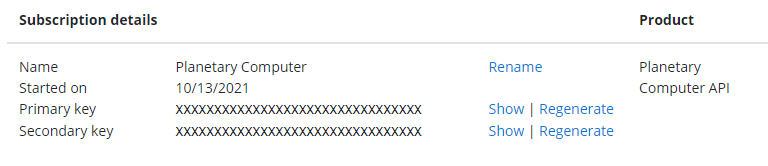 

In this first example, let's define 1st quarter of 2019 as the time range for the analysis. 

In [15]:
with open('../subscription.key', 'r') as file:
    subscription_key = file.read()

processor = FloodProcessor(
    aoi_df = gdf,
    output_dir='../tmp',
    subscription_key=subscription_key,
    time_range='2019-01/2019-03'
)

In [16]:
# Now, let's create the water series. For that, we need to pass a RF model. 
processor.find_water(model_path='../model/RF_Model_v2.joblib', resume=True)
processor.process_floods(use_hand=False)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

## Visualizing the results

The results can be visualized directly from the `FloodProcessor` class. All the available variables can be seen by calling the representation of the class, like so:

In [17]:
processor

Flood Processor for place: tmp
Variables: ['aoi_df', 'recurrence', 'waters', 'water_series', 'data_table', 'max_flood', 'floods']
WaterFinder for place tmp
Available dates: 9
Water detected dates: 9

<Axes: >

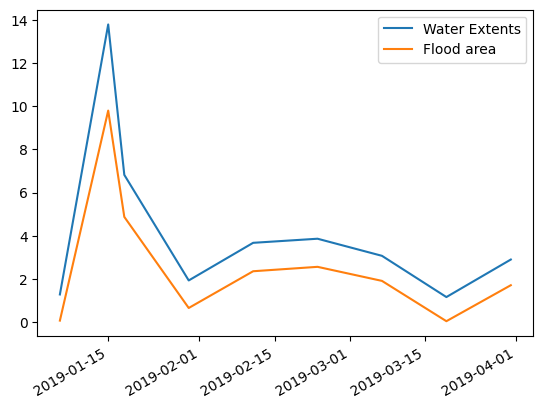

In [18]:
# First, let's plot the series
processor['data_table'].plot()

<Axes: title={'center': 'Flood for 2019-01-15'}, xlabel='x', ylabel='y'>

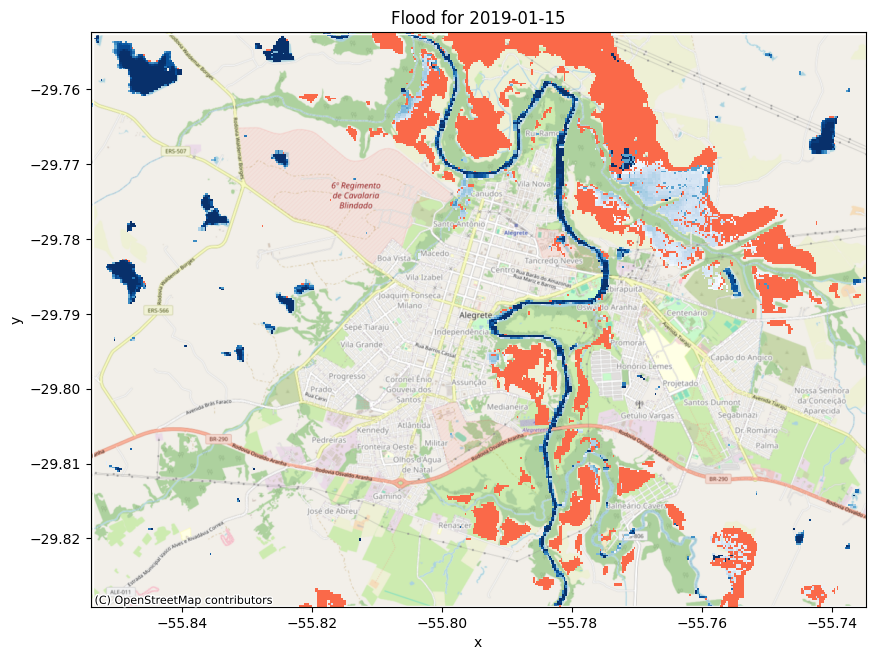

In [19]:
# to plot the flood for a specific date, we can call the `plot_flood` method

processor.plot_flood(date='2019-01-15', background=cx.providers.OpenStreetMap.Mapnik, recurrence_threshold=10)

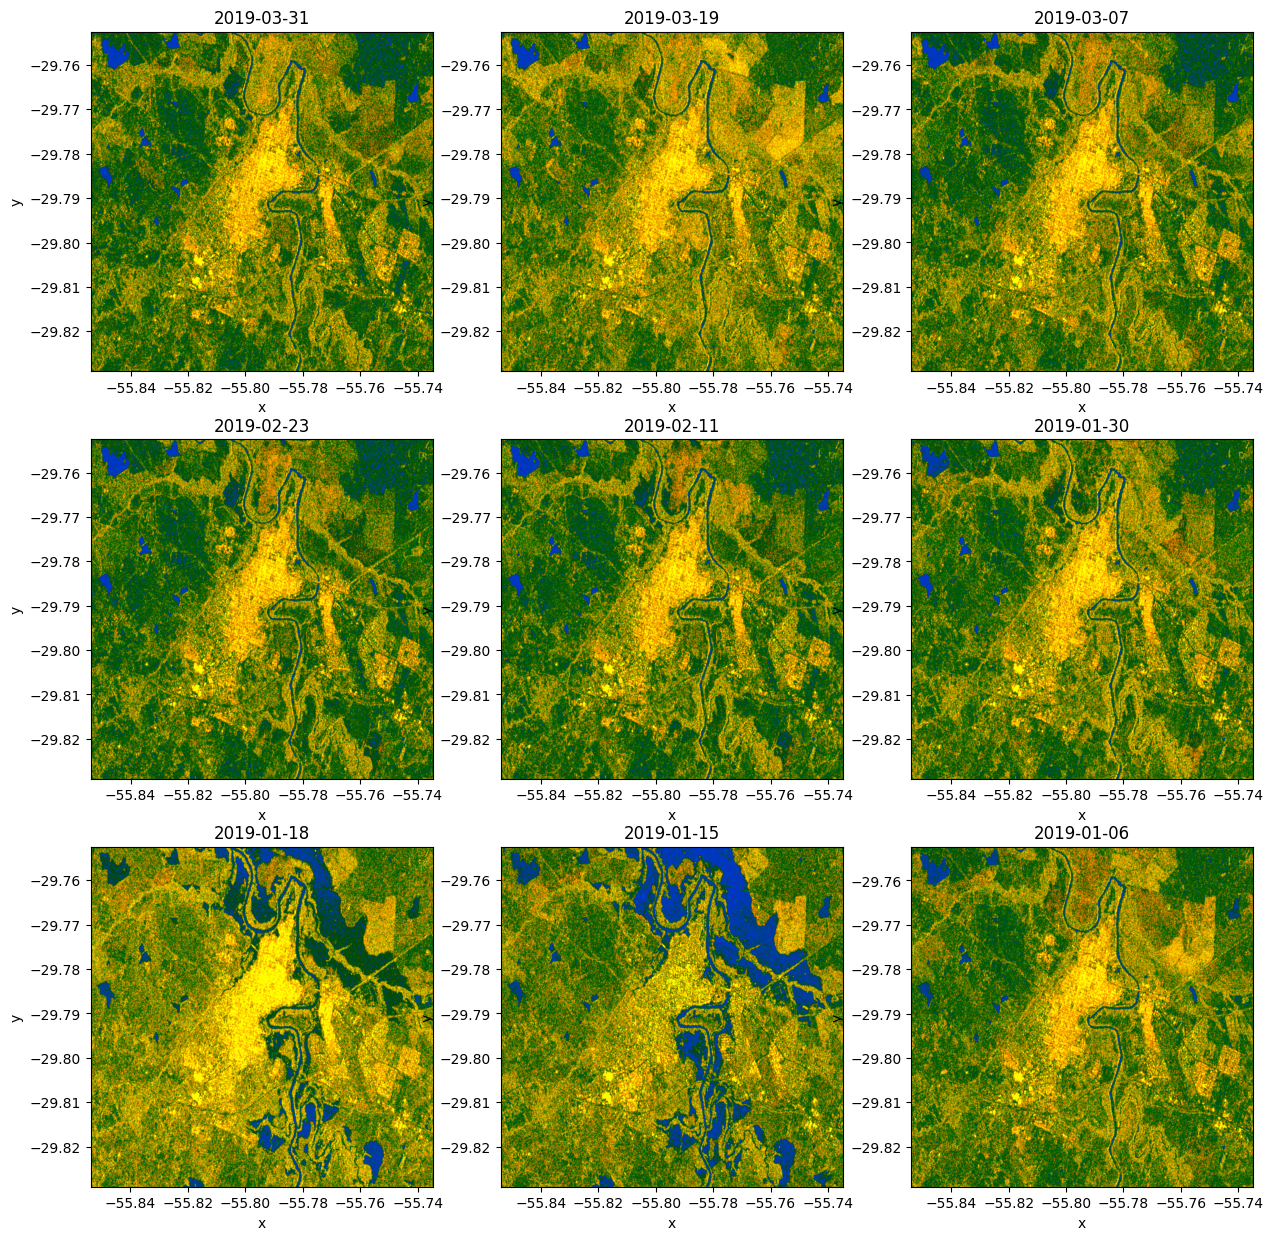

In [20]:
# To plot the Sentinel1 images used in the detection, we can access the `finder` member. 
# as we have 9 images within the period, let's create a 3x3 grid to display them:

fig, axs = plt.subplots(3,3, figsize=(15,15))

for idx, ax in enumerate(axs.reshape(-1)):
    date = processor.finder.s1imagery.dates[idx]
    processor.finder.s1imagery.plot_date(date, ax=ax, raw=True)
